# Literatur


- Bernini, Antonio, and Federico Talamucci. 2014. Consonance of Complex Tones with Harmonics of Different Intensity. In: Open Journal of Acoustics, 04: 78-89. 
- Cook, Norman. 2009. Harmony Perception: Harmoniousness is More Than the Sum of Interval Consonance. In: Music Perception, 27: 25-42.
- Dillon, Giorgio. 2013. Calculating the Dissonance of a Chord according to Helmholtz Theory. In: European Physical Journal Plus, 128.
- Fowler, David. 2004. Helmholtz: combinational tones and consonance. In: John Fauvel, Raymond Flood, and Robin Wilson (ed.). Music and Mathematics: From Pythagoras to Fractals, 77-88. Mew York: Oxford University Press.
- Helmholtz, Hermann ¬von. 1968. Die Lehre von den Tonempfindungen als physiologische Grundlage für die Theorie der Musik (7., unveränd. Aufl., reprograf. Nachdr. der 6. Aufl., Braunschweig 1913.). Hildesheim: Olms.
- Loy, Gareth. 2011. Musimathics: The Mathematical Foundations of Music Volume 1. Cambridge: MIT Press.
- Mashinter, Keith. 2006. Calculating Sensory Dissonance: Some Discrepancies Arising from the Models of Kameoka & Kuriyagawa, and Hutchinson & Knopoff. In: Empirical Musicology Review, 1: 65-84.
- Parncutt, Richard and Graham Hair. 2011. Consonance and dissonance in music theory and psychology: Disentangling dissonant dichotomies. In: Journal of Interdisciplinary Music Studies, 5: 119-166.
- Sethares, William. 1993. Local consonance and the relationship between timbre and scale. In: The Journal of the Acoustical Society of America, 94: 1218-1228.
- Sethares, William. 2005. Tuning, Timbre, Spectrum, Scale. London: Springer.
- Stange, Karolin, Christoph Wick, and Haye Hinrichsen. 2017. Playing Music in Just Intonation - A Dynamically Adapting Tuning Scheme. In: Computer Music Journal, 42: 1-22.
- Zwicker, E. 1961. Subdivision of the audible frequency range into critical bands. In: The Journal of the Acoustical Society of America, 33, 2: 248-249

# Setup

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
import time

%matplotlib inline

# Plotting

In [249]:
#either dissonance measure or nr_partial (not both) can be a list for comparisson
def plot_dissonance(dissonance_measure, interval_range=(1,2),
                    base_freq = 261, fundamentals_vol = (1,1),
                    nr_partials = None, partials_pos = None, partials_vol = None,
                    scaling = None, labels = None):
    """Plots the dissonance curve of one or more given dissonance measures.
    A Dissonance curve plots the dissonance of two tones as a function of the interval they form, when one of 
    the tones stays fixed and the frequency of the other tone variesin a given range.

    A dissonance measure is a function that takes four lists of floats:
    fundamentals, fundamentals_vol, partials_pos, partials_vol
    and returns a float: The dissonance that results when a set of tones with volumes given in fundamentals_vol,
    and fundamental frequencies given in fundamentals sound together, where the tones are complexe tones with 
    partials at the positions given in partials_pos and intensities (relative to the total intensity of each 
    tone) given in partials_vol.

    Parameters
    ----------
    dissonance_measure: function or List of functions or np.Array of functions
        The dissonance measure to be plotted.
        If a list of dissonance measures is given, they are all plotted.
    interval_range: (float, float)
        the lower and higher margin of the interval range to be plotted
        where 1 is the unison, 2 the octave etc. (Default value = (1,2))
    base_freq: float
        The frequency of the fundamental of the fixed tone. (Default value = 261)
    fundamentals_vol: (float, float)
        The volume of both tones. (Default value = (1,1))
    nr_partials: None or int or list or range of ints
        The number of partials of the tones.
        If a list of ints is given, a plot is drawn for each number of partials.
        You can give a list as either dissonance_measure or nr_partials, not both.
        If None is given, nr_partials is set to 6.
        (Default value = None)
    partials_pos: None or list of floats
        The position of the partials of the complex sounds.
        E.g. [1,2] means the tones have to partials: the fundamental and an overtone at the octave.
        If None is given, partials_pos is set to [1,...,nr_partials] 
        i.e. the fundamental and the first nr_partials-1 harmonic overtones.
        (Default value = None)
    partials_vol: None or list of floats
        The volume of the partials of the complex tones.
        If None is given or the list is not long enough, partials_vol is set to
        [0.88^0,...,0.88^(nr_partials-1)], i.e. exponentially decreasing overtones.
        (Default value = None)
    scaling: None or list of floats
        The scaling of dissonance measures is arbitrary, for easier comparrisson when plotting,
        scaling factors can be given as a list.
        If None is given, scaling factors are all 1.
        (Default value = None)
    labels: None or list of Strings
        If a list of dissonance measures is given, a list of labels can be given to determine the 
        labels of the plots.
        If None is given, the measures are called Dissonance Measure 1, 2, 3, etc.    
    """
    
    if partials_pos is None:
        if isinstance(nr_partials, list) or isinstance(nr_partials, range):
            partials_pos = list(range(1, max(nr_partials) + 1)) # fundamental & harmonic overtones
            if partials_vol is None or len(partials_vol) < max(nr_partials):
                partials_vol = [0.88**i for i in range(max(nr_partials))] # Sethares 1993: 1219
        else:
            if nr_partials is None:
                nr_partials = 6
            partials_pos = list(range(1, nr_partials + 1)) # fundamental & harmonic overtones
            if partials_vol is None:
                partials_vol = [0.88**i for i in range(nr_partials)] # Sethares 1993: 1219
    
    intervals = np.arange(interval_range[0], interval_range[1], 0.005)
    
    fig, ax = plt.subplots()
    
    if isinstance(nr_partials, list) or isinstance(nr_partials, range):
        for nr in nr_partials:
            ax.plot(intervals, np.vectorize(
                lambda interval: dissonance_measure([base_freq, base_freq * interval], fundamentals_vol,
                                                      partials_pos[:nr], partials_vol[:nr])
            )(intervals), label='%i partials' % nr)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    elif isinstance(dissonance_measure, list) or isinstance(dissonance_measure, np.ndarray):
        if scaling is None or len(scaling) < len(dissonance_measure):
            scaling = [1 for _ in dissonance_measure]
        
        if labels is None or len(labels) < len(dissonance_measure):
            labels = ['Dissonance Measure %i' % i for i in range(1, len(dissonance_measure) + 1)]
        
        for i in range(len(dissonance_measure)):
            diss = dissonance_measure[i]
            ax.plot(intervals, np.vectorize(
                lambda interval: diss([base_freq, base_freq * interval], fundamentals_vol,
                                      partials_pos, partials_vol) * scaling[i]
            )(intervals), label=labels[i])
        ax.legend()
    else:
        ax.plot(intervals, np.vectorize(
            lambda interval: dissonance_measure([base_freq, base_freq * interval], fundamentals_vol,
                                                 partials_pos, partials_vol)
        )(intervals))
        
        if labels is not None:
            ax.legend([labels[0]])
    
    
    # reference intevals for the grid:
    reference_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]  # Just Intonation
    #reference_intervals = [2**(i/12) for i in range(0,13)]  # Equal Temperament
    degree_names = ['u', 'm2', 'M2', 'm3', 'M3', '4', 't', '5', 'm6', 'M6', 'm7', 'M7', 'o']
    
    # take only the ticks that I need
    needed_intervals = [i >= interval_range[0] and i <= interval_range[1] for i in reference_intervals]
    
    ax.set_xticks(np.array(reference_intervals)[needed_intervals])
    ax.set_xticklabels(np.array(degree_names)[needed_intervals])
    ax.xaxis.grid(True)
    plt.show()

In [243]:
def plot_dissonance_2d(dissonance_measure, base_freq = 261,
                       nr_partials = 6, partials_pos = None, partials_vol = None):
    """Plots the dissonance of three note chord as calculated by a given dissonance measures.
    A Dissonance curve plots the dissonance of all combinations of three tones within an octave
    as a (2 dimenional) function of the intervals the higher ones form with the lower one.

    A dissonance measure is a function that takes four lists of floats:
    fundamentals, fundamentals_vol, partials_pos, partials_vol
    and returns a float: The dissonance that results when a set of tones with volumes given in fundamentals_vol,
    and fundamental frequencies given in fundamentals sound together, where the tones are complexe tones with 
    partials at the positions given in partials_pos and intensities (relative to the total intensity of each 
    tone) given in partials_vol.

    Parameters
    ----------
    dissonance_measure: function
        The dissonance measure to be plotted.
    base_freq: float
        The frequency of the fundamental of the fixed tone. (Default value = 261)
    nr_partials: int
        The number of partials of the tones. (Default value = 6)
    partials_pos: None or list of floats
        The position of the partials of the complex sounds.
        E.g. [1,2] means the tones have to partials: the fundamental and an overtone at the octave.
        If None is given, partials_pos is set to [1,...,nr_partials] 
        i.e. the fundamental and the first nr_partials-1 harmonic overtones.
        (Default value = None)
    partials_vol: None or list of floats
        The volume of the partials of the complex tones.
        If None is given or the list is not long enough, partials_vol is set to
        [0.88^0,...,0.88^(nr_partials-1)], i.e. exponentially decreasing overtones.
        (Default value = None)       
    """
    
    
    
    fundamentals_vol = [1, 1, 1]
    
    if partials_pos is None:
        partials_pos = list(range(1, nr_partials + 1)) # fundamental & harmonic overtones
    if partials_vol is None:
        partials_vol = [0.88**i for i in range(nr_partials)] # Sethares 1993: 1219
    
    def dissonance_interval(interval_1, interval_2):
        return dissonance_measure([base_freq, base_freq * interval_1, base_freq * interval_2],
                                    fundamentals_vol, partials_pos, partials_vol)
    
    intervals = np.arange(1, 2, 0.01)
    dissonance_map = np.array([[dissonance_interval(i1, i2) for i1 in intervals] for i2 in intervals])
    
    # reference intevals for the grid:
    reference_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]  # Just Intonation
    #reference_intervals = [2**(i/12) for i in range(0,13)]  # Equal Temperament
    degree_names = ['u', 'm2', 'M2', 'm3', 'M3', '4', 't', '5', 'm6', 'M6', 'm7', 'M7', 'o']
    
    fig, ax = plt.subplots()
    c = ax.imshow(np.flipud(dissonance_map))
    fig.colorbar(c, ax=ax)
    ax.set_xticks((np.array(reference_intervals) - 1) * len(intervals))
    ax.set_xticklabels(degree_names)
    ax.xaxis.grid(True)
    ax.set_yticks((2 - np.array(reference_intervals)) * len(intervals))
    ax.set_yticklabels(degree_names)
    ax.yaxis.grid(True)
    plt.show()

# Dissonances

## Amplitude and Loudness

In [250]:
# https://de.wikipedia.org/wiki/Schalldruck
# https://de.wikipedia.org/wiki/Schalldruckpegel
# https://de.wikipedia.org/wiki/Phon_(Einheit)
# Loy 2011: 169
# Sethares 2005: 346
a = 0.5
# for sine of freq 2 kHz the threshold of hearing is 0 approx
# if I play a sine of that frequency with sc3nb: %sc {SinOsc.ar(2000, 0, *a*)!2}.play
# the threshold of hearing with my laptop speakers under normal conditions yields a = 0.00005
# -> choose factor digital_to_real such that for a = 0.00005, a_spl = 0
# this is obviously only a very rough approximation, especially since my laptop speakers are definitely not linear
digital_to_real = 2 * 10000 * 2**0.5
a_real = a * digital_to_real  # Schalldruckamplitude
a_eff = a_real / 2**0.5  # Effektivwert des Schalldrucks
# Amplitude to Sound Pressure Level (SPL, Schalldruckpegel) in dB:
a_spl = 20 * np.log10(a_eff)

# as a very rough approximation of perceived loudness in phon, I subtrackt the threshold of hearing of a certain
# frequency from the sound pressure level of a tone of that frequency
def threshold_of_hearing(f):
    f = f / 1000
    return  3.64 * f**(-0.8) - 6.5 * np.exp(-0.6 * (f - 3.3)**2) + 0.001 * f**4
freq = 200
a_phon = a_spl - threshold_of_hearing(freq)
a_phon

66.82936822104729

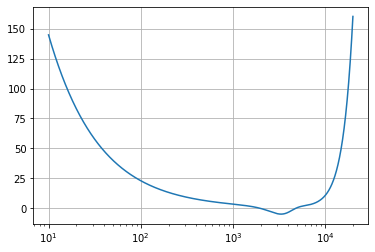

In [251]:
freqs = np.logspace(np.log2(10), np.log2(20000), num=1000, base=2)
plt.semilogx(freqs, threshold_of_hearing(freqs))
plt.grid(True)

## Stange

In [252]:
# Stange, Wick & Hinrichsen 2017

# not realy a dissonance measure, just summed the quadratic distance of every interval
# between fundamentals, independent of their overtones or volume
# not wise to search this objective function explicitly for local optima
# there are more efficient ways
# Stange et all use this only implicitly as their objective function
# I used it hear just as a simple test

ju_intervals = [1, 16/15, 9/8, 6/5, 5/4, 4/3, 45/32, 3/2, 8/5, 5/3, 9/5, 15/8, 2]
et_intervals = [2**(i/12) for i in range(0,13)]

def stange_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    target_intervals = ju_intervals  # et_intervals
    
    # calculates the interval if the two fundamentals whould transposed into the same octave
    # i.e. Ci : Gj is a fifth (3/2) for all octaves i and j
    def calc_interval(f1, f2):
        return 2**(np.log2(f1 / f2) % 1)
    
    # squared distance to the next JU-interval
    def interval_diss(interval):
        return np.min([(interval - i)**2 for i in target_intervals])
    
    intervals = [calc_interval(fundamentals[i], fundamentals[j])
                 for j in range(len(fundamentals)) for i in range(j + 1, len(fundamentals))]
    
    return sum([interval_diss(interval) for interval in intervals])

## Additive Dissonances

In [253]:
# Most dissonance measures in the literature calculate a dissonance measure for complex tones
# by calculating the dissonance for every pair of simple tones and adding them up
# this is a general function to add up the dissonance of every pair of partials calculated
# with a given dissonance measure of a list of fundamentals with given frequencies and volumes
# and partials with given volumes at given position

# if symmetric, the algorithm only consideres dissonances between partials that belong to different fundamentals
# assuming that the basic dissonance is symmetric and that we are not interested in the inner Dissonance of the
# Timbre thus reducing the amount of basic dissonances that need to be calculated from
# fundamentals^2 * partials^2 eg 3^2 * 7^2 = 441
# to 
# (fundamentals - 1) * fundamentals / 2 * partials^2 eg (3 - 1) * 3 / 2 * 7^2 = 147

def additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, basic_dissonance,
                        symmetric = False):
    if symmetric:
        return sum([
            basic_dissonance(
                fundamentals[i] * partials_pos[k],
                fundamentals[j] * partials_pos[l],
                fundamentals_vol[i] * partials_vol[k],
                fundamentals_vol[j] * partials_vol[l]
            )
            for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(i + 1, len(fundamentals))]
            for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
        ])
    else:
        return 0.5 * sum([
            basic_dissonance(
                fundamentals[i] * partials_pos[k],
                fundamentals[j] * partials_pos[l],
                fundamentals_vol[i] * partials_vol[k],
                fundamentals_vol[j] * partials_vol[l]
            )
            for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(len(fundamentals))]
            for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
        ])

## Helmholtz

In [254]:
# Helmholtz 1968: 318

# basic dissonance: x^2 / (30^2 + x^2)^2 aus Fowler 2004: 86
# I multiply with 3600 to set the max to 1 for easier comparisson with other measures
# indepenent of intensity of partials and critical band

def helmholtz_basic_dissonance(p1, p2, v1, v2):
    beat_freq = abs(p1 - p2)
    return 3600 * beat_freq**2 / ((30**2 + beat_freq**2)**2)

def helmholtz_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, helmholtz_basic_dissonance)

## Sethares

In [255]:
# Sethares 1993
# see http://sethares.engr.wisc.edu/comprog.html

def sethares_basic_dissonance(p1, p2, v1, v2):
    # parameters from Sethares 1993: 1219-1220
    a = 3.5
    b = 5.75
    d = 0.24
    s1 = 0.021
    
    s2 = 19.
    s = d / (s1 * min(p1, p2) + s2)
    diff = abs(p2 - p1)
    return v1 * v2 * (np.exp(-a * s * diff) - np.exp(-b * s * diff))

def sethares_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, sethares_basic_dissonance)

## Sethares 2005

In [256]:
# Sethares 2005: 345
# The algorithm Sethares describes in 2005 contains some minor differences to his original 1993 version

def sethares_2006_basic_dissonance(p1, p2, v1, v2):
    if p1 > p2:
        p1, p2dd = p2, p1
    
    b1 = 3.5
    b2 = 5.75
    d = 0.24
    s1 = 0.021
    s2 = 19
    
    s = d / (s1 * p1 + s2)
    
    # loudness processing (new in 2005)
    v = min(v1, v2)
    # constant 4.3... approximated by me to fit the loudness of my laptop speaker, see "Amplitude and Loudness"
    spl = 20 * (np.log10(v) + 4.30102999566398)
    l = 1 / 16 * 2**(spl / 10)
    
    return l * (np.exp(-b1 * s * (p2 - p1)) - np.exp(-b2 * s * (p2 - p1)))

def sethares_2006_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    total_diss = additive_dissonance(fundamentals, fundamentals_vol,
                                     partials_pos, partials_vol,
                                     sethares_2006_basic_dissonance)
    return total_diss

## Sethares Plus

In [257]:
# Sethares + weighting loudness of Partials with inverse Fletcher-Munson curves as suggested by Sethares 1993: 1226
# There are more recent definitions (especially ISO 226:2003) but they don't provide a closed formula
# idea: dissonance at 10000 with 10 partials should be equal to dissonance at 440 with one partial
# because the overtones of a tone with frequency 10000 are outside the human hearing range

# somewhat arbitrary conversion of the threshold of hearing into a sensitivity, better done in bernini
# +6 to get max to be 1
def sensitivity_factor(f):
    return 1 / (threshold_of_hearing(f) + 6)

def sethares_basic_dissonance_plus(p1, p2, v1, v2):
    a = 3.5
    b = 5.75
    d = 0.24
    s1 = 0.021
    s2 = 19.
    s = d / (s1 * min(p1, p2) + s2)
    diff = abs(p2 - p1)
    sensitivity = min(sensitivity_factor(p1), sensitivity_factor(p2)) * v1 * v2
    return v1 * v2 * (np.exp(-a * s * diff) - np.exp(-b * s * diff)) * sensitivity

def sethares_dissonance_plus(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, sethares_basic_dissonance_plus)

## Dillon

In [258]:
# dillon 2013
# critical bandwidth (d) from Loy 2011 or actually originally Zwicker and Fastl 1990

# I like the basic dissonance function (without the **3 and **6 in the last line)
# it is simpler and more narrow than the others
# but I don't get the thing with the powers - the curve doesn't have pronunced minima
# and some minima collapse in a way that new ones arise at places where there shouldn't be a min
# also it's unclear to me how he measures loudness:
# is his l the amplitude, the objective loudness or the subjective loudness (phon)


def dillon_basic_dissonance(p1, p2, v1, v2):
    n = 4.906
    mean = (p1 + p2) * 0.5
    b = 25 + 75 * (1 + 1.4 * (mean / 1000)**2)**0.69
    x = abs(p1 - p2) / b
    if x > 1.2:
        return 0.
    else:
        d = n * x * (1.2 - x)**4
        
        return (v1 * v2)**3 * d**6

def dillon_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    s = additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, dillon_basic_dissonance)
    return s**(1/6)


## Bernini

In [259]:
# Bernini 2014
# The desired effect (Dissonance is higher when the lower Frequency is louder) seems to be extremely small
# and doesn't effect the minima -> not interesting for me
# but the effect of loudness is less extreme as with Sethares and the effect of the hearing threshold
# (partials above 20kHz don't count) is very nice
# interesting to see that the basic dissonance is very narrow in comparisson with Sethares, like Dillon


critical_band_width = lambda x: 91.43 + 0.0257 * x + 0.000052393 * x**2 - 0.0000000070515 * x**3 \
                        + 0.00000000000035803 * x**4
simple_diss = lambda x: 1 - (0.9994 - 10.461 * x + 36.422 * x**2 - 48.808 * x**3 + 29.693 * x**4 - 6.8823 * x**5)

def bernini_basic_dissonance(p1, p2, v1, v2):
    mean = (p1 + p2) / 2
    h = abs(p1 - p2) / critical_band_width(mean)
    if h > 1.2:
        return 0
    else:
        d = simple_diss(h)
        
        
        # translate v1, v2 to phon
        v1 = 20 * (np.log10(v1) + 4.30102999566398) - threshold_of_hearing(p1)
        v2 = 20 * (np.log10(v2) + 4.30102999566398) - threshold_of_hearing(p2)
        v1 = np.log(1+np.exp(v1))  # Softplus because negative values would yield errors later on
        v2 = np.log(1+np.exp(v2))  # ReLU would be more efficient but yields discontinuities
        
        if p2 < p1:
            v1, v2 = v2, v1  # make sure v1 corresponds to the lower frequency (v1 corresponds to x in Bernini)
        
        if v1 < v2:
            alpha = 0.2  # alpha is Berninis alpha
        else:
            alpha = 0.8  # alpha is Berninis alpha1
        f = ((v1+v2)/2)**alpha * (v1*v2)**((1-alpha)/2)
        
        return d * f

def bernini_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, bernini_basic_dissonance)


## Kameoka and Kuriyagawa

In [260]:
# As described in Mashinter 2006
# I don't get why the Dissonance has a min between m2 and M2, it looks like an error in my implementation
# especially for Timbres with week overtones I get results that make no sense to me
# But Figure 1 in Mashinter 2006 has a similar min between m2 and M2 so maybe it's not my fault?
# On the other hand Figure 4 looks like a normal dissonance curve

def kameoka_basic_dissonance(p1, p2, v1, v2):
    # not in the paper but throws exceptions otherwise - the logs are very sensitive to low volumes
    if v1 < 0.00038 or v2 < 0.00038:
        return 0.
    
    # Constants for translating relative dissonance to absolute dissonance
    k0 = 1.0
    C0 = 65.
    
    # make sure p1, p2 belong to the lower partial
    if p1 > p2:
        p1, p2 = p2, p1
        v1, v2 = v2, v1
    
    # translate v1, v2 to SPL (my own approximation)
    v1 = 20 * (np.log10(v1) + 4.30102999566398)
    v2 = 20 * (np.log10(v2) + 4.30102999566398)
    
    # frequency of maximal dissonance
    fb = 2.27 * ((v1 - 57) / 40. + 1) * p1**0.477
    
    # calculating absolute dissonance d2ei
    if p2 > 2*p1 or (p2 - p1) / p1 <= 0.01:  # Supra-octave or near unison domain
        D2ei = k0 * C0  # Dissonance of empiric background noise Dn0
    elif p2 - p1 < fb:  # Dynamic domain
        D2ei = k0 * (100 * (2 + np.log((p2 - p1) / p1)) / (2 + np.log(fb / p1)) + C0)
    else:  # Static domain
        D2ei = k0 * (90 * np.log((p2 - p1) / p1) / np.log(fb / p1) + 10 + C0)
    
    # Conversion to dissonance intensity
    beta = 0.25
    DI2ei = (D2ei / k0)**(1. / beta)
    
    # Intensity of noise
    DIn = C0**(1. / beta)
    
    # Dissonance without noise
    if DI2ei < DIn:
        D2ei = 0.  # not in the paper but for DI2ei < DIn (DI2ei - DIn)**beta is not defined...
    else:
        D2ei = k0 * (DI2ei - DIn)**beta
    
    # translate SPL back to amplitude in microbar
    v1 = 10**(v1 / 20.) / 5000.
    v2 = 10**(v2 / 20.) / 5000.
    
    # Loudness-corrected Dissonance
    v0 = 2 * 10**(-1.15)
    nh = 0.15
    nl = 0.32
    ne = 0.20
    if v1 == v2:
        D2i = D2ei * (v1 / v0)**ne
    elif v1 > v2:  # partial with lower frequency has higher amplitude
        D2i = D2ei * (v1 / v0)**ne * (v2 / v1)**nh
    else:
        D2i = D2ei * (v2 / v0)**ne * (v1 / v2)**nl
    
    # Conversion to dissonance intensity
    DI2i = (D2i / k0)**(1. / beta)
    
    return DI2i

def kameoka_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    k0 = 1.0
    C0 = 65.
    beta = 0.25
    DIn = C0**(1. / beta)
    
    # add up intensities
    DIt = additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, kameoka_basic_dissonance)
    
    # add noise intensity and convert back from intensity
    Dm = k0 * (DIt + DIn)**beta
    
    return Dm


## Hutchinson and Knopoff / Parncutt

In [261]:
# As described in Mashinter 2006
# approximation of Plomp and Levelt by Parncutt, R. (1989). Harmony: A Psychoacoustical Approach. Springer-Verlag.
# most narrow basic dissonance so far
# dissonance is allways in (0,1), thats quite nice!
# minima are less pronounced as with other measures

def hutchinson_basic_dissonance(p1, p2, v1, v2):
    a = 0.25
    b = 2.
    
    mean = (p1 + p2) / 2
    cbw = 1.72 * mean**0.65
    y = abs(p1 - p2) / cbw
    g = (y / a * np.exp(1 - (y / a)))**b
    
    return v1 * v2 * g

def hutchinson_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    
    # add up squared intensities
    vol_sum = sum([(fundamentals_vol[i] * partials_vol[j])**2
                   for i in range(len(fundamentals)) for j in range(len(partials_vol))])
    
    if vol_sum <= 0:
        return 0
    
    # add up basic dissonances
    diss_sum = additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, hutchinson_basic_dissonance)
    
    return diss_sum / vol_sum * 2


## Cook

In [262]:
# Cook 2009
# Somehow the basic dissonance doesn't result in anything remotely similar to Sethares even though he claims
# this is basically Sethares - I'm pretty sure it's a mistake in the paper
# I'll take just my implementation of Sethares instead

# The calculation of the tension of all triads is just to expensive, not feasible for a live aplication
# besides - this is more about the comparisson of the hight of the minima than about changing the location
# of minima, and since I'm not interested in global minima but local minima (intergrity of musical material)
# I don't care if I get the hight of the minima wrong

def cook_basic_dissonance(p1, p2, v1, v2):
    if p1 == p2:
        return 0
    elif p1 < p2:
        x = np.log(p2/p1)
    else:
        x = np.log(p1/p2)
    
    beta1 = -0.8
    beta2 = -1.6
    beta3 = 4.
    
    return v1 * v2 * beta3 * (np.exp(-beta1 * x) - np.exp(-beta2 * x))

def cook_basic_tension(p1, p2, p3, v1, v2, v3):
    if p1 == p2 or p1 == p3 or p2 == p3:
        return 0.
    
    p1, p2, p3 = sorted((p1, p2 , p3))
    x = np.log(p2 / p1)
    y = np.log(p3 / p2)
    v = v1 * v2 * v3
    
    return v * np.exp(-((y-x)/0.6)**2)

def cook_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    dissonance = sum([
        sethares_basic_dissonance(
            fundamentals[i] * partials_pos[k],
            fundamentals[j] * partials_pos[l],
            fundamentals_vol[i] * partials_vol[k],
            fundamentals_vol[j] * partials_vol[l]
        )
        for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(len(fundamentals))]
        for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
    ])
    
    tension = sum([
        cook_basic_tension(
            fundamentals[i] * partials_pos[l],
            fundamentals[j] * partials_pos[m],
            fundamentals[k] * partials_pos[n],
            fundamentals_vol[i] * partials_vol[l],
            fundamentals_vol[j] * partials_vol[m],
            fundamentals_vol[k] * partials_vol[n]
        )
        for (i,j,k) in [(i,j,k) for i in range(len(fundamentals)) for j in range(len(fundamentals)) for k in range(len(fundamentals))]
        for (l,m,n) in [(l,m,n) for l in range(len(partials_pos)) for m in range(len(partials_pos)) for n in range(len(partials_pos))]
    ])
    
    return dissonance + 0.2 * tension


## Harmonic Entropy

In [79]:
# farey series
def farey_series(n):
    if n == 1:
        return [(0,1),(1,1)]
    elif n > 1:
        f_old = farey_series(n - 1)
        f_new = []
        for i in range(len(f_old)):
            f_new.append(f_old[i])
            if i+1 < len(f_old) and f_old[i][1] + f_old[i+1][1] == n:
                f_new.append((f_old[i][0] + f_old[i+1][0], f_old[i][1] + f_old[i+1][1]))
        return f_new

775


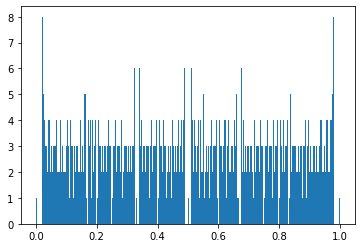

In [19]:
farey_series_50 = [f[0] / f[1] for f in farey_series(50)]
print(len(farey_series_50))
plt.hist(farey_series_50, bins=300)
plt.show()

In [18]:
# As described in Sethares 2005: 371
# interesting concept! but extremely expensive computation-wise, definitely not usabel in a live system

farey_series_50 = farey_series(14)  # Sethares uses order 50 for his plot, not duable on my machine

# probability that interval i is perceived as a mistuning of the jth member of the Farey series
def probability(i,j):
    rj_lim = ((farey_series_50[j-1][0] + farey_series_50[j][0]) / (farey_series_50[j-1][1] + farey_series_50[j][1]),
              (farey_series_50[j+1][0] + farey_series_50[j][0]) / (farey_series_50[j+1][1] + farey_series_50[j][1]))
    
    return scipy.stats.norm.cdf(rj_lim[1], loc=i, scale=0.007) - scipy.stats.norm.cdf(rj_lim[0], loc=i, scale=0.007)

def basic_entropy(p1, p2, v1, v2):
    # interval in range 0-1
    i = 2**(np.log2(p2 / p1) % 1) - 1
    return -sum([probability(i,j) * np.log(probability(i,j))
                 for j in range(1, len(farey_series_50) - 1)
                 if probability(i,j) > 0])

def total_entropy(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol, basic_entropy,
                               symmetric = True)


## Frankenstein

Let $C$ be a set of complex tones, each with partials $P$. Every complex tone $i \in C$ consists of partials $k \in P$, i.e. simple tones with frequency $f_{i,k}$ and amplitude $a_{i,k}.$

The total dissonance of complex tones $C$ with overtones $P$ is given by:

$D(C,P) = \sum_{i < j \in C} \sum_{k,l \in P} d_{i,j,k,l} v_{i,j,k,l}$

with basic dissonance factor (roughness of two simple tones):

$d_{i,j,k,l} = \begin{cases} 4.906 h_{i,j,k,l} (h_{i,j,k,l} - 1.2)^4 & h \le 1.2 \\ 0 & h_{i,j,k,l} > 1.2 \end{cases}$

where $h_{i,j,k,l}$ is the distance of the simple tones relative to the critical bandwidth:

$h_{i,j,k,l} = \frac{|f_{i,k} - f_{j,l}|}{cbw_{i,j,k,l}}$

where $cbw_{i,j,k,l}$ is an approximation of the critical bandwidth at the mean frequency:

$cbw_{i,j,k,l} = 25 + 75 (1 + 1.4*10^{-6} (\frac{f_{i,k}+f_{j,l}}{2})^2)^{0.69}$

and volume factor:

$v_{i,j,k,l} = p_{i,k}p_{j,l}$

where $p_{i,k}$ is an approximation of the subjective loudness in phon of the partial $k$ of complex tone $i$:

$p_{i,k} = \log(1+a_{i,k}^{8.685889}\exp(89 - 914.327 f_{i,k}^{-0.8} - 10^{-15} * f_{i,k}^4))$

In [246]:
# my own dissonance measure build from my favourite parts of the beforementioned ones.
# Dissonance curve looks very similar to bernini (without the problem of insensitive to
# the amplitude described below) but is actually the fastest of the dissonance curves,
# even without using symmetric=True!

def frankenstein_basic_dissonance(p1, p2, v1, v2):
    mean = (p1 + p2) / 2
    critical_band_width = 25 + 75 * (1 + 1.4e-6 * mean**2)**0.69  # taken from Dillon
    h = abs(p1 - p2) / critical_band_width
    
    if h >= 1.2:
        return 0
    
    d = 4.906 * h * (1.2 - h)**4  # taken from Dillon

    # translate v1, v2 to phon, similar to what I used in my Bernini implementation
    # but simplified and optimized (see Component Evaluation)
    # f much simpler
    v1 = np.log(1 + v1**8.685889 * np.exp(86 - 914.327 * p1**-0.8 - 1e-15 * p1**4))
    v2 = np.log(1 + v2**8.685889 * np.exp(86 - 914.327 * p2**-0.8 - 1e-15 * p2**4))
    f = v1 * v2
    
    return d * f


def frankenstein_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    return additive_dissonance(fundamentals, fundamentals_vol, partials_pos, partials_vol,
                               frankenstein_basic_dissonance, symmetric=True)


In [214]:
# same function as frankenstein_dissonance but with np.arrays instead of for loops
def frankenstein_dissonance_vec(fundamentals, fundamentals_vol, partials_pos, partials_vol):
    
    # a row corresponds to a complex tone
    positions = np.outer(fundamentals, partials_pos)
    volumes = np.outer(fundamentals_vol, partials_vol)
    
    # all pairs of partials and their volumes
    # including for every two partials only one pair
    # a partial does not form a pair with itself
    args = np.array([
        [positions[i,k],
        positions[j,l],
        volumes[i,k],
        volumes[j,l]]
        for (i,j) in [(i,j) for i in range(len(fundamentals)) for j in range(i + 1, len(fundamentals))]
        for (k,l) in [(k,l) for k in range(len(partials_pos)) for l in range(len(partials_pos))]
    ])  
    
    p1s = args[:,0]
    p2s = args[:,1]
    v1s = args[:,2]
    v2s = args[:,3]
    
    means = (p1s + p2s)/2
    critical_band_widths = 25 + 75 * (1 + 1.4e-6 * means**2)**0.69
    hs = np.abs(p1s - p2s) / critical_band_widths
    
    cond = np.where(hs < 1.2)
    hs = hs[cond]
    p1s = p1s[cond]
    p2s = p2s[cond]
    v1s = v1s[cond]
    v2s = v2s[cond]
    
    ds = 4.906 * hs * (1.2 - hs)**4
    
    v1s = np.log(1 + v1s**8.685889 * np.exp(86 - 914.327 * p1s**-0.8 - 1e-15 * p1s**4))
    v2s = np.log(1 + v2s**8.685889 * np.exp(86 - 914.327 * p2s**-0.8 - 1e-15 * p2s**4))
    fs = v1s * v2s
    
    return np.sum(ds * fs)


In [215]:
%timeit frankenstein_dissonance([400,600,435,124,623],[1,0.8,1,0.3, 0.5],range(1,12),partials_vol_piano)
%timeit frankenstein_dissonance_vec([400,600,435,124,623],[1,0.8,1,0.3, 0.5],range(1,12),partials_vol_piano)

9.89 ms ± 490 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.68 ms ± 276 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Evaluation

## Component Evaluation

The dissonance measures of Bernini, Dillon and Hutchinson can be dissected into components that can be tested individually: The function that takes the frequency difference (relative to the critical band) and returns the perceived roughness of to simple tones with that difference and the function that estimates the width of the critical band at a certain frequency.

Also: Optimization of my function that translates amplitude to phon.

Results:
- The roughness curve is nearly identical for all formulas, Dillon is the fastest, BUUUUT the roughness of Hutchinson is continuously differentiable at $x = 0$, nearly quadratic at $0<x<0.01$ and as it turns out this is a huge pro when optimizing, making optimization much more reliable and also faster
- For the critical band width, Dillon has the best fit to the empirical data by Zwicker 1961, computation time is extremely small for all of them.

### Roughness

In [263]:
beats_bernini = lambda x: 1 - (0.9994 - 10.461 * x + 36.422 * x**2 - 48.808 * x**3 + 29.693 * x**4 - 6.8823 * x**5)
beats_dillon = lambda x: 4.906 * x * (1.2 - x)**4
beats_hutchinson = lambda x: (x / 0.25 * np.exp(1 - (x / 0.25)))**2

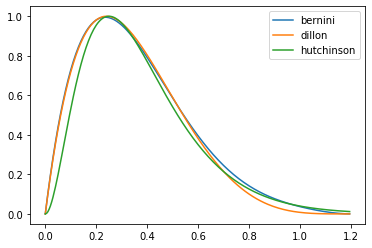

In [265]:
xs = np.arange(0, 1.2, 0.005)
plt.plot(xs, np.vectorize(beats_bernini)(xs), label='bernini')
plt.plot(xs, np.vectorize(beats_dillon)(xs), label='dillon')
plt.plot(xs, np.vectorize(beats_hutchinson)(xs), label='hutchinson')
plt.legend()

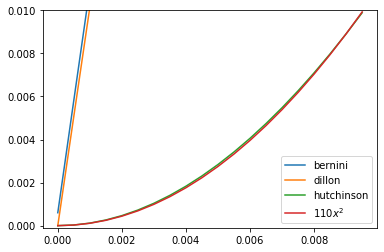

In [283]:
xs = np.arange(0, 0.01, 0.0005)
plt.plot(xs, np.vectorize(beats_bernini)(xs), label='bernini')
plt.plot(xs, np.vectorize(beats_dillon)(xs), label='dillon')
plt.plot(xs, np.vectorize(beats_hutchinson)(xs), label='hutchinson')
plt.plot(xs, np.vectorize(lambda x: 110 * x**2)(xs), label='$110 x^2$')
plt.ylim(-0.0001, 0.01)
plt.legend()

In [267]:
%timeit beats_bernini(0.4)
%timeit beats_dillon(0.4)
%timeit beats_hutchinson(0.4)

1.12 µs ± 11.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
393 ns ± 9.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5.1 µs ± 132 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Critical Band Width

In [24]:
bw_bernini = lambda x: 91.43 + 0.0257 * x + 0.000052393 * x**2 - 0.0000000070515 * x**3 \
                        + 0.00000000000035803 * x**4
bw_dillon = lambda x: 25 + 75 * (1 + 1.4 * (x / 1000)**2)**0.69
bw_hutchinson = lambda x: 1.72 * x**0.65

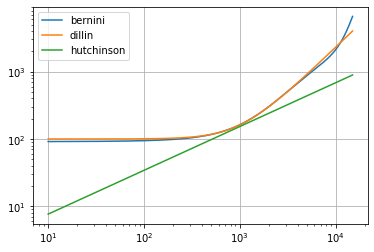

In [43]:
freqs = np.logspace(np.log2(10), np.log2(15000), num=1000, base=2)
fig, ax = plt.subplots()
ax.plot(freqs, np.vectorize(bw_bernini)(freqs), label='bernini')
ax.plot(freqs, np.vectorize(bw_dillon)(freqs), label='dillin')
ax.plot(freqs, np.vectorize(bw_hutchinson)(freqs), label='hutchinson')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

In [46]:
# empirical bandwidths taken from Zwicker 1961: 248
center_freqs = [60, 150, 250, 350, 450, 570, 700, 840, 1000, 1170, 1370, 1600,
                1850, 2150, 2500, 2900, 3400, 4000, 4800, 5800, 7000, 8500,10500, 13500]
bandwidth = [80, 100, 100, 100, 110, 120, 140, 150, 160, 190, 210, 240, 280,
             320, 380, 450, 550, 700, 900, 1100, 1300, 1800, 2500, 3500]
errors = lambda fun: [abs(bandwidth[i] - fun(center_freqs[i])) / center_freqs[i] for i in range(len(center_freqs))]

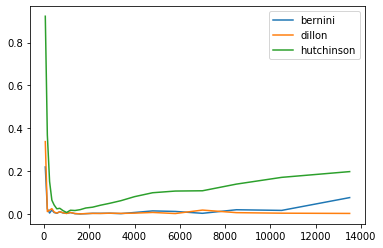

In [49]:
plt.plot(center_freqs, errors(bw_bernini), label='bernini')
plt.plot(center_freqs, errors(bw_dillon), label='dillon')
plt.plot(center_freqs, errors(bw_hutchinson), label='hutchinson')
plt.legend()

In [27]:
%timeit bw_bernini(0.4)
%timeit bw_dillon(0.4)
%timeit bw_hutchinson(0.4)

839 ns ± 9.87 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
682 ns ± 7.29 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
320 ns ± 9.83 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### Amplitude to Phon

In [129]:
# claculating the threshold of hearing without the little "bump" at ca 3300 Hz is much faster
# an since I'm primarily interested in the boundaries at 20 Hz and 15000 Hz I can do without the bump

def threshold_of_hearing_1(f):
    f = f / 1000
    return  3.64 * f**(-0.8) - 6.5 * np.exp(-0.6 * (f - 3.3)**2) + 0.001 * f**4
def threshold_of_hearing_2(f):
    f = f / 1000
    return  3.64 * f**(-0.8) + 0.001 * f**4

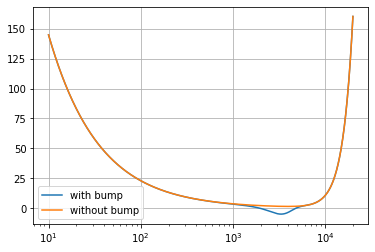

In [132]:
freqs = np.logspace(np.log2(10), np.log2(20000), num=1000, base=2)
plt.semilogx(freqs, threshold_of_hearing_1(freqs), label='with bump')
plt.semilogx(freqs, threshold_of_hearing_2(freqs), label='without bump')
plt.legend()
plt.grid(True)

In [128]:
%timeit threshold_of_hearing_1(1000)
%timeit threshold_of_hearing_2(1000)

4.74 µs ± 54.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
395 ns ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [158]:
# The implementation I used in my implementation of bernini
def amp_to_phon_1(v,f):
    v = 20 * (np.log10(v) + 4.30102999566398) - threshold_of_hearing_1(f)
    v = np.log(1+np.exp(v))
    return v

# The simpler threshold function and formula transformed to spare a log
def amp_to_phon_2(v,f):
    threshold = threshold_of_hearing_2(f)
    v = np.log(1 + v**(20 / np.log(10)) * np.exp(20*4.3 - threshold))
    return v

# Constants approximated
def amp_to_phon_3(v,f):
    return np.log(1 + v**8.685889 * np.exp(86 - threshold_of_hearing_2(f)))

# threshold of hearing-formula copied directly into the function and constants approximated
def amp_to_phon_4(v,f):
    return np.log(1 + v**8.685889 * np.exp(86 - 914.327 * f**-0.8 - 1e-15 * f**4))

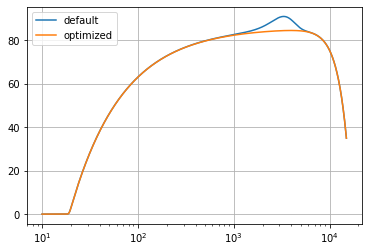

In [159]:
freqs = np.logspace(np.log2(10), np.log2(15000), num=1000, base=2)
fig, ax = plt.subplots()
ax.plot(freqs, np.vectorize(lambda f: amp_to_phon_1(1, f))(freqs), label='default')
ax.plot(freqs, np.vectorize(lambda f: amp_to_phon_4(1, f))(freqs), label='optimized')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend()
ax.grid(True)

In [160]:
%timeit amp_to_phon_1(0.78,1234.5)
%timeit amp_to_phon_2(0.78,1234.5)
%timeit amp_to_phon_3(0.78,1234.5)
%timeit amp_to_phon_4(0.78,1234.5)

20.6 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
15.3 µs ± 96 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
10.3 µs ± 385 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
9.68 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## "Holistic" Evaluation

In [229]:
# amplitudes of the piano-synth I defined in sc3
partials_vol_piano = np.array([3.7, 5.4, 1.2, 1.1, 0.95, 0.6, 0.5, 0.65, 0.001, 0.1, 0.2]) / 5.4

# partials with harmonic decline (I read somewhere that that's a violin)
partials_vol_harm = [1 / i for i in range(1,12)]

In [82]:
# usable measure with their names and scaling for easier comparisson

measures = np.array([helmholtz_dissonance, sethares_dissonance, sethares_2006_dissonance, sethares_dissonance_plus, bernini_dissonance, hutchinson_dissonance, frankenstein_dissonance])
labels = np.array(['Helmholtz', 'Sethares', 'Sethares 2006', 'Sethares Plus', 'Bernini', 'Hutchinson', 'Frankenstein'])
scaling = np.array([0.1, 3, 0.1, 40, 0.0005, 1])

In [87]:
# just an easy way to choose which measures to compare

compare = [1,2,4,5]
compare = [i in compare for i in range(len(measures))]
print(labels[compare])

['Sethares' 'Sethares 2006' 'Bernini' 'Hutchinson']


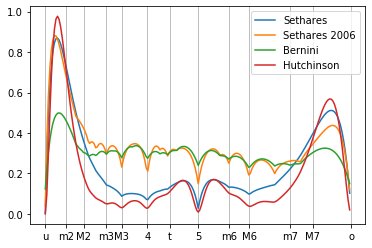

In [38]:
# Helmholtz is ignorant of loudnes -> cannot see that the last overtones are very quiet -> to ragged
# Sethares Plus needs extremely loud overtones (exponential with base 0.88 is ok), to smooth otherwise

plot_dissonance(measures[compare],
                base_freq=261*2,
                nr_partials=11,
                partials_vol=partials_vol_piano,
                labels=labels[compare],
                scaling=scaling[compare])

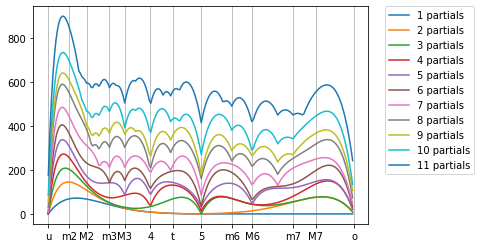

In [177]:
# bernini seem to insensitive to the amplitude: partial 9 should add next to nothing to the curve
# nevertheless, Bernini contains some nice "shortcuts" to return 0 early, maybe I can incorporate them
# also bernini is the only measure incuorporating subjective loudness, see next cell

plot_dissonance(bernini_dissonance, nr_partials=range(1,12), partials_vol=partials_vol_piano)

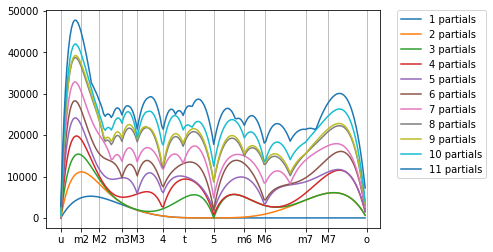

In [195]:
plot_dissonance(frankenstein_dissonance, nr_partials=range(1,12), partials_vol=partials_vol_piano)

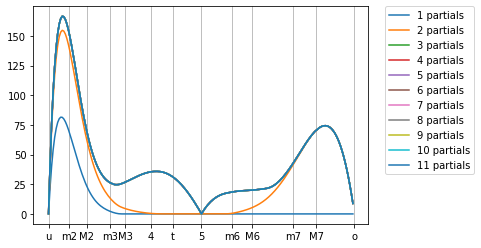

In [324]:
# the 4th partial (and every partial above) is outside the human hearing range
# only bernini takes that into account!

plot_dissonance(bernini_dissonance, base_freq=5000, nr_partials=range(1,12), partials_vol=partials_vol_piano)

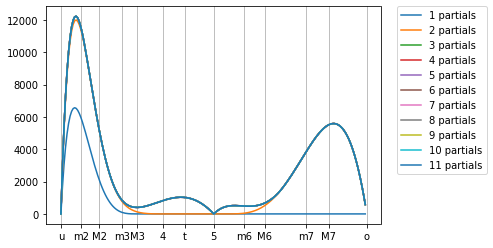

In [241]:
plot_dissonance(frankenstein_dissonance_vec, base_freq=5000, nr_partials=range(1,12), partials_vol=partials_vol_piano)

In [230]:
%%timeit
helmholtz_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

2.79 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [231]:
%%timeit
sethares_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

6.43 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [232]:
%%timeit
sethares_2006_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

10.7 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [233]:
%%timeit
sethares_dissonance_plus([400,600],[1,1],range(1,12),partials_vol_piano)

14.4 ms ± 74.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [234]:
%%timeit
bernini_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

7.38 ms ± 80.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [235]:
%%timeit
hutchinson_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

5.22 ms ± 67.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [236]:
%%timeit
frankenstein_dissonance([400,600],[1,1],range(1,12),partials_vol_piano)

1.14 ms ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [237]:
%%timeit
frankenstein_dissonance_vec([400,600],[1,1],range(1,12),partials_vol_piano)

652 µs ± 5.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Not usable

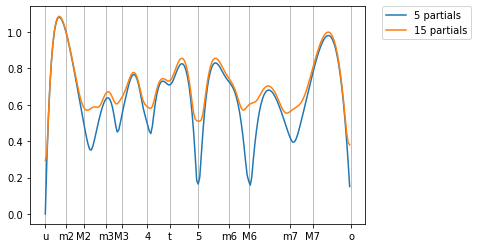

In [42]:
# bad minima between major and minor thirds and sixths

plot_dissonance(dillon_dissonance, base_freq=261*2, nr_partials=[5,15])

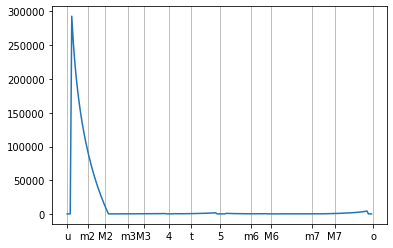

In [39]:
# very strange behaviour, especially for fast declining partials, not sure if it's my implemention or the model..
# to complex and computationaly expensive anyway

partial_decline = 0.5
plot_dissonance(kameoka_dissonance, base_freq=261, nr_partials=5,
                partials_vol=[partial_decline**i for i in range(5)])

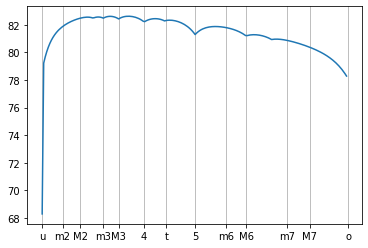

In [40]:
# calculating the tension of every tripel is just to expensive and probably unnecessary for my aims
# because im not searching for global optima, also very flat dissonance curve

plot_dissonance(cook_dissonance, base_freq=261, nr_partials=7)

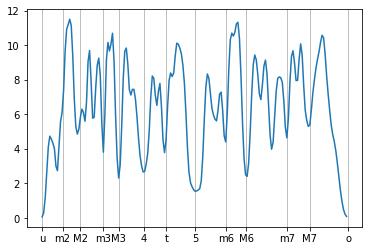

In [47]:
# calculating the entropy for a big enough farey_series to get a good objective function is much to expensive
# interesting concept though...

plot_dissonance(total_entropy, base_freq=261, nr_partials=3)